In [1]:
import numpy  as np
import pandas as pd
import os
import scipy.io
import pickle
import matplotlib.pyplot as plt

from scipy.interpolate    import UnivariateSpline, griddata, CubicSpline
from scipy.optimize       import curve_fit
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Constants and Inputs
NTOT        = 1000                                      # Total grid points
delta_star0 = 0.01102                                   # Displacement thickness [m] at the start of the integration (x_0)
theta_0     = 0.00818 / delta_star0                     # Momentum thickness [m] at the start of the integration (x_0)
angle       = np.array([-8, -4, 0, 4, 8])               # Angles of attack in degrees
u0_         = np.array([19.1, 19.0, 19.2, 19.2, 19.2])  # Freestream velocity (m/s) at x_0
ni_         = 1.516e-5                                  # Kinematic viscosity (m^2/s)
wid1        = np.array([0.4, 0.5, 0.5, 0.25, 0.25])     # Initial values used to fit a double-gaussian model to the Oil Film Interferometry data 
wid1        = [w * 10**6 for w in wid1]  
wid2        = np.array([0.6, 0.5, 0.5, 0.25, 0.5])
wid2        = [w* 10**6 for w in wid2]
scheme      = 'implicit'                                # Use implicit scheme for numerical stability
weight      = 'linear'                                  # Weighting function for the evaluation of the distance effects onto widetilde{beta}
model       = 'lag'                                     # Type of ODEs used to close the problem
k           = 1                                         # Esponent value of the 2D sigmoid function used to evaluate widetilde{beta} (in Matlab k=1.977)
kappa       = 0.384                                     # von Kármán constant
C           = 2.127                                     # Logarithmic law constant
D0          = 220                                       # Correction term constant for high Reynolds numbers
D1          = 0                                         # Additional correction term (set to zero)
C1          = 7.135                                     # Shape factor constant
E1          = -19.12                                    # Reynolds-dependent correction term

In [3]:
# Directories
dir0  = r'F:\Research Fluid Dynamics\University of Southampton\MIE solver folder\TurboPGH_Final_Version\Code calibrated with TBLs under wing\functions and data'
dir01 = os.path.join(dir0, 'data_from_PIV') 
dir1  = os.path.join(dir0, 'Cp_Mean.mat')
dir8  = os.path.join(dir0, 'Cf_Oil_Film_Interferometry')
dir3  = os.path.join(dir01, 'SW_PIV_Summary_-8.mat')
dir4  = os.path.join(dir01, 'SW_PIV_Summary_-4.mat')
dir5  = os.path.join(dir01, 'SW_PIV_Summary_0.mat')
dir6  = os.path.join(dir01, 'SW_PIV_Summary_4.mat')
dir7  = os.path.join(dir01, 'SW_PIV_Summary_8.mat')
dir9  = os.path.join(dir01, 'U_inf_AOA_Tom')

In [4]:
# Color scheme
color_vel = {
    -8: [1.0, 0.0, 0.0],  # Red for AOA = -8
    -4: [0.5, 0.0, 0.0],  # Dark red for AOA = -4
     0: [0.0, 0.0, 0.0],  # Black for AOA = 0
     4: [0.0, 0.0, 0.5],  # Dark blue for AOA = 4
     8: [0.0, 0.0, 1.0],  # Blue for AOA = 8
}

In [5]:
# Computation of dimensionless parameters
u0      = np.array([1, 1, 1, 1, 1])           # Dimensionless free stream velocity at x_0
rho     = 1;                                  # Dimensionless density
ni      = ni_ / (np.mean(u0_) * delta_star0)  # Non-dimensional viscosity

In [6]:
# Load of pressure gradient data
cp_load = scipy.io.loadmat(dir1)   # Cp coefficient
x_      = cp_load['tap_m']         # x location of the pressure taps

In [7]:
# Allocation of variables
# struct variables
d_star                = {}
d_star['data']        = {}
theta_meas            = {}
theta_meas['data']    = {}
axial_pos1            = {}
axial_pos1['data']    = {}
velFreeStream         = {}
velFreeStream['data'] = {}
axial_pos             = {}
axial_pos['data']     = {}
# Arrays
dpdx_m                = np.zeros((x_.shape[1],5))
Cf                    = np.zeros((96,5))
Re                    = np.zeros((96,5))
u_inf                 = np.zeros((NTOT,5))
dpdx                  = np.zeros((NTOT-1,5))
D                     = np.zeros(96)
Cf_fit                = np.zeros((NTOT-1,5))
deltastar             = np.zeros((NTOT-1,5))
theta_m_fit           = np.zeros((NTOT-1,5))
DdeltastarDx          = np.zeros((NTOT-1,5))
tau_w                 = np.zeros((NTOT-1,5))
Cf_c                  = np.zeros((NTOT-1,5))
dCfdx                 = np.zeros((NTOT-1,5))
beta                  = np.zeros((NTOT-1,5))
Cf_zpg                = np.zeros((NTOT-1,5))
dCf_zpg_dx            = np.zeros((NTOT-1,5))
H_zpg                 = np.zeros((NTOT-1,5))
deltastar_zpg         = np.zeros((NTOT-1,5))
Ddeltastar_zpgDx      = np.zeros((NTOT-1,5))
Delta_ddeltasdx       = np.zeros((NTOT-1,5))
Delta_dCfdx           = np.zeros((NTOT-1,5))
BetaOverbar           = np.zeros((NTOT-1,5))
beta_all              = np.zeros((NTOT-1)*5)
BetaOverbar_all       = np.zeros((NTOT-1)*5)
C4_m_all              = np.zeros((NTOT-1)*5) 
C5_m_all              = np.zeros((NTOT-1)*5) 
theta_solver          = np.zeros((NTOT-1,5))
tau_w_solver          = np.zeros((NTOT-1,5))
delta_star_solver     = np.zeros((NTOT-1,5))
Cf_solver             = np.zeros((NTOT-1,5))
beta_solver           = np.zeros((NTOT-1,5))
BetaOverbar_solver    = np.zeros((NTOT-1,5))
Ddelta_star_solverDx  = np.zeros((NTOT-1,5))
dCfdx_solver          = np.zeros((NTOT-1,5))

In [8]:
# Model of a gaussian function centered at cen=!0
def gaussian(X, amp, cen, wid):
    """line + 1-d gaussian"""
    gauss = (amp / (np.sqrt(2*np.pi) * wid)) * np.exp(-(X-cen)**2 / (2*wid**2))
    return gauss

In [9]:
# Model of a double-gaussian function
def Cf_curve(X, Cf_end, Cf_start, wid1, wid2, peak, cen):
    amp1 = (peak - Cf_start) * (np.sqrt(2*np.pi) * wid1)
    amp2 = (peak - Cf_end) * (np.sqrt(2*np.pi) * wid2)
    if len(X) > 1:    
        X_peak         = np.where(X <= cen)[0][-1]
        fit            = np.zeros(len(X))
        fit[:X_peak+1] = gaussian(X[:X_peak+1], amp1, cen, wid1) + Cf_start
        fit[X_peak+1:] = gaussian(X[X_peak+1:], amp2, cen, wid2) + Cf_end
    else:
        if X[0] > cen:
            fit = gaussian(X[0], amp2, cen, wid2) + Cf_end
        if X[0] <= cen:
            fit = gaussian(X[0], amp1, cen, wid1) + Cf_start
    return(fit)

In [10]:
# Function to compute the pressure gradients history effects
def mov_upstr_mean(x, N, mode, k):
    """
    Compute a moving upstream mean for an array x.
    Parameters:
    x : array-like
        Input array.
    N : int
        Length parameter for the computation.
    mode : str
        Weighting mode ('gaussian' or 'linear').
    k : float
        Sigmoid sharpness parameter.
    Returns:
    result : ndarray
        The resulting array of moving upstream means.
    """
    x      = np.array(x)  # Ensure input is a NumPy array
    dx     = np.abs(np.gradient(x))  # Compute gradients
    result = np.zeros_like(x)  # Initialize the result array

    if N == len(x):
        for i in range(1, N + 1):
            # Define Gaussian parameters
            a = 1  # Amplitude
            b = i  # Mean (peak at the end of the array)
            c = 0.5  # Standard deviation

            indices = np.arange(1, i + 1)

            # Compute weights based on the selected mode
            if mode == 'gaussian':
                weights_s = a * np.exp(-((indices - b) ** 2) / (2 * c ** 2))
            elif mode == 'linear':
                weights_s = indices
            else:
                raise ValueError("Invalid mode. Choose 'gaussian' or 'linear'.")

            # Normalize the weights
            s = weights_s / np.max(weights_s)
            t = dx[:i] / np.max(dx[:i])

            # Compute modified sigmoid weights
            sigmoid_s = 1 / (1 + np.exp(-k * (s - 0.5)))
            sigmoid_t = 1 / (1 + np.exp(-k * (t - 0.5)))
            weights   = sigmoid_s * sigmoid_t

            # Apply weights and compute weighted mean
            weighted_x    = x[:i] * weights
            result[i - 1] = np.mean(weighted_x)

    else:
        for i in range(1, len(x)):
            # Compute the mean of the interval x(1:i)
            result[i] = np.mean(x[:i + 1])

    return result

In [11]:
for j in range(5):
    ####################################################################################################################################################
    # load the Cp coefficient and retrieve the pressure gradient values
    # Load the free-stream velocity U_inf
    # Load skin friction and Re from OFI data
    ####################################################################################################################################################
  if j == 0:          # AOA = -8 degrees
        dp            = cp_load['meight_500mm']*0.5*rho*(u0_[j]**2)
        y1            = dp[0,:]/(rho*(u0_[j]**2))
        x1            = x_[0,:]/delta_star0
        dpdx_m[:,j]   = np.gradient(y1,x1)
        del x1, y1
        Uinf_load     = scipy.io.loadmat(os.path.join(dir9, 'Uinf_PIV-8.mat'))
        intParam_load = scipy.io.loadmat(dir3)
        cf_load       = scipy.io.loadmat(os.path.join(dir8, 'Cf_minus8'))
        re_load       = scipy.io.loadmat(os.path.join(dir8, 'Re_minus8'))
        cf_loaded     = cf_load['Cf_vec1']
        re_loaded     = re_load['Re_vec1']
        Cf[:,j]       = cf_loaded[:,1]
        Re[:,j]       = re_loaded[:,1]
     ###################################################################################################################################################       
  elif j == 1:        # AOA = -4 degrees
        dp            = cp_load['mfour_500mm']*0.5*rho*(u0_[j]**2)
        y1            = dp[0,:]/(rho*(u0_[j]**2))
        x1            = x_[0,:]/delta_star0
        dpdx_m[:,j]   = np.gradient(y1,x1)
        del x1, y1
        Uinf_load     = scipy.io.loadmat(os.path.join(dir9, 'Uinf_PIV-4.mat'))
        intParam_load = scipy.io.loadmat(dir4)
        cf_load       = scipy.io.loadmat(os.path.join(dir8, 'Cf_minus4'))
        re_load       = scipy.io.loadmat(os.path.join(dir8, 'Re_minus4'))
        cf_loaded     = cf_load['Cf_vec2']
        re_loaded     = re_load['Re_vec2']
        Cf[:,j]       = cf_loaded[:,1]
        Re[:,j]       = re_loaded[:,1]
     ###################################################################################################################################################   
  elif j == 2:        # AOA = 0 degrees
        dp            = cp_load['zero_500mm']*0.5*rho*(u0_[j]**2)
        y1            = dp[0,:]/(rho*(u0_[j]**2))
        x1            = x_[0,:]/delta_star0
        dpdx_m[:,j]   = np.gradient(y1,x1)
        del x1, y1
        Uinf_load     = scipy.io.loadmat(os.path.join(dir9, 'Uinf_PIV0.mat'))
        intParam_load = scipy.io.loadmat(dir5)
        cf_load       = scipy.io.loadmat(os.path.join(dir8, 'Cf_0'))
        re_load       = scipy.io.loadmat(os.path.join(dir8, 'Re_0'))
        cf_loaded     = cf_load['Cf_vec3']
        re_loaded     = re_load['Re_vec3']
        Cf[:,j]       = cf_loaded[:,1]
        Re[:,j]       = re_loaded[:,1]
     ###################################################################################################################################################   
  elif j == 3:        # AOA = 4 degrees
        dp            = cp_load['four_500mm']*0.5*rho*(u0_[j]**2)
        y1            = dp[0,:]/(rho*(u0_[j]**2))
        x1            = x_[0,:]/delta_star0
        dpdx_m[:,j]   = np.gradient(y1,x1)
        del x1, y1
        Uinf_load     = scipy.io.loadmat(os.path.join(dir9, 'Uinf_PIV4.mat'))
        intParam_load = scipy.io.loadmat(dir6)
        cf_load       = scipy.io.loadmat(os.path.join(dir8, 'Cf_4'))
        re_load       = scipy.io.loadmat(os.path.join(dir8, 'Re_4'))
        cf_loaded     = cf_load['Cf_vec4']
        re_loaded     = re_load['Re_vec4']
        Cf[:,j]       = cf_loaded[:,1]
        Re[:,j]       = re_loaded[:,1]
     ###################################################################################################################################################   
  elif j == 4:        # AOA = 8 degrees
        dp            = cp_load['eight_500mm']*0.5*rho*(u0_[j]**2)
        y1            = dp[0,:]/(rho*(u0_[j]**2))
        x1            = x_[0,:]/delta_star0
        dpdx_m[:,j]   = np.gradient(y1,x1)
        del x1, y1
        Uinf_load     = scipy.io.loadmat(os.path.join(dir9, 'Uinf_PIV8.mat'))
        intParam_load = scipy.io.loadmat(dir7)
        cf_load       = scipy.io.loadmat(os.path.join(dir8, 'Cf_8'))
        re_load       = scipy.io.loadmat(os.path.join(dir8, 'Re_8'))
        cf_loaded     = cf_load['Cf_vec5']
        re_loaded     = re_load['Re_vec5']
        Cf[:,j]       = cf_loaded[:,1]
        Re[:,j]       = re_loaded[:,1]
  ######################################################################################################################################################
  # Spline interpolations of the experimental data over the 1d mesh x with NTOT points  
  velFreeStream['data'][j] = Uinf_load['Uinf']/u0_[j]
  axial_pos['data'][j]     = Uinf_load['X']/delta_star0
  x1                       = axial_pos['data'][j]
  y1                       = velFreeStream['data'][j]
  del Uinf_load
  splineFit                = UnivariateSpline(x1[0,:], y1[0,:],s=0.05)
  del x1, y1
  x                        = np.linspace(x_.min(),x_.max(),NTOT)/delta_star0
  u_inf[:,j]               = splineFit(x)
  x1                       = x_/delta_star0
  y1                       = dpdx_m[:,j]
  splineFit1               = CubicSpline(x1[0,:], y1)
  dpdx[:,j]                = splineFit1(x[0:-1])
  Dx                       = np.diff(x) 
  ##################################################### Oil film Interferometry
  # 2 Gaussian fits for the Cf data from OFI
  d_star['data'][j]     = intParam_load['deltastar_m']/delta_star0
  theta_meas['data'][j] = intParam_load['theta_m']/delta_star0
  axial_pos1['data'][j] = intParam_load['X_m']/delta_star0
  S                     = np.argsort(Re[:, j])   
  Re[:,j]               = Re[S, j]
  Cf[:,j]               = Cf[S, j]
  X                     = Re[:,j]
  Y1                    = pd.Series(Cf[:,j])
  Y_                    = Y1.interpolate(method='linear')
  rolling_mean          = pd.Series(Y_).rolling(window=20, center=True, min_periods=1).mean()
  deviation             = np.abs(Y_-rolling_mean)
  idx                   = deviation <= 3*np.nanstd(Y_)
  C_                    = Y_[idx]
  D[~idx]               = np.nan
  D[idx]                = C_
  Y2                    = pd.Series(D)
  Y                     = Y2.interpolate(method='linear')
  del idx
    ###################
  if j == 4:
      val               = np.min(Y)
      idx               = np.argmin(Y)
  else:
      val               = np.max(Y)
      idx               = np.argmax(Y) 
    ###################
  initial_guess         = [Y.iloc[-1], Y.iloc[0], wid1[j], wid2[j], val, X[idx]]
  Y                     = Y.to_numpy()
  popt, pcov            = curve_fit(Cf_curve, X, Y, p0=initial_guess)
  X_opt                 = x[0:-1]*u0[j]/ni
  Y_opt                 = Cf_curve(X_opt,*popt)  
  Reynolds              = X_opt
  Cf_fit[:,j]           = Y_opt
  del x1, y1
  x1                    = axial_pos1['data'][j]
  y1                    = d_star['data'][j]
  splineFit2            = UnivariateSpline(x1[0,:], y1[0,:],s=1)  
  deltastar[:,j]        = splineFit2(x[0:-1])
  del y1
  y1                    = theta_meas['data'][j]
  splineFit3            = UnivariateSpline(x1, y1,s=0.05)
  theta_m_fit[:,j]      = splineFit3(x[0:-1]) 
  del x1, y1
  x1                    = x[0:-1]
  y1                    = deltastar[:,j]
  DdeltastarDx[:,j]     = np.gradient(y1, x1)
  ##################################### arrays for the calibration of the model
  # Compute coefficients for calibration
  # Wall shear stress
  tau_w[:, j]            = rho * Cf_fit[:, j] * u0[j]**2
  # Skin friction coefficient
  Cf_c[:, j]             = tau_w[:, j] / (0.5 * rho * u_inf[0:-1, j]**2)
  # Cf gradient
  dCfdx[:, j]            = np.gradient(Cf_c[:, j], x[0:-1]) 
  # Pressure gradient parameter
  beta[:, j]             = dpdx[:, j] * deltastar[:, j] / tau_w[:, j]  
  # Compute the Reynolds number based on x and u_inf
  # Local Reynolds number based on distance x and free-stream velocity u_inf
  Re_x                   = x[0:-1] * u_inf[0:-1, j] / ni    
  # Compute the zero-pressure-gradient (ZPG) momentum thickness
  # Analytical formula for ZPG boundary layer momentum thickness
  theta_zpg              = x[0:-1] * 0.037 / (Re_x**(1/5))  
  # Compute Reynolds number based on theta_zpg and u_inf
  # Reynolds number based on theta_zpg and local u_inf
  Re_theta               = theta_zpg * u_inf[0:-1, j] / ni  
  # Compute skin friction coefficient (Cf) for ZPG boundary layers
  # Empirical Cf formula
  Cf_zpg[:, j]           = 2 * ((1 / kappa) * np.log(Re_theta) + C + D0 * np.log(Re_theta) / Re_theta + D1 / Re_theta)**(-2)  
  dCf_zpg_dx[:, j]       = np.gradient(Cf_zpg[:, j], x[0:-1])  # Gradient of Cf_zpg with respect to x
  # Compute shape factor (H) for ZPG boundary layers
  # Non-dimensional velocity
  U_infplus              = np.sqrt(2 / Cf_zpg[:, j])
  # Empirical formula for shape factor
  H_zpg[:, j]            = 1 / (1 - (C1 / U_infplus)) + E1 / Re_theta  
  # Compute displacement thickness (\delta^*) for ZPG boundary layers
  # Displacement thickness using shape factor and momentum thickness
  deltastar_zpg[:, j]    = H_zpg[:, j] * theta_zpg 
  # Gradient of displacement thickness with respect to x
  Ddeltastar_zpgDx[:, j] = np.gradient(deltastar_zpg[:, j], x[0:-1])  
  # Compute deviations from ZPG values for \delta^* and Cf
  # Deviation in \delta^* gradients
  Delta_ddeltasdx[:, j]  = DdeltastarDx[:, j] - Ddeltastar_zpgDx[:, j]  
  # Deviation in Cf gradients
  Delta_dCfdx[:, j]      = dCfdx[:, j] - dCf_zpg_dx[:, j]  
  # Calibration for \delta^*
  # C4_m                   = (DdeltastarDx[:, j] - Ddeltastar_zpgDx[:, j]) / deltastar_zpg[:, j]
  C4_m                   = (DdeltastarDx[:, j] - Ddeltastar_zpgDx[:, j]) / deltastar[:, j]
  # Calibration for Cf
  # C5_m                   = (dCfdx[:, j] - dCf_zpg_dx[:, j]) / Cf_zpg[:, j]
  C5_m                   = (dCfdx[:, j] - dCf_zpg_dx[:, j]) / Cf_c[:, j]
  BetaOverbar[:,j]       = mov_upstr_mean(beta[:,j],len(beta[:,j]),weight,k)
  del Y, Y1
  Y                      = pd.Series(beta[:,j])
  Y1                     = Y.interpolate(method='linear')
  beta[:,j]              = Y1.to_numpy()
  del Y, Y1
  Y                      = pd.Series(BetaOverbar[:,j])
  Y1                     = Y.interpolate(method='linear')
  BetaOverbar[:,j]       = Y1.to_numpy()
  # Number of data points for the current calibration
  M                      = len(beta[:, j])  
  # Update arrays for the current calibration
  # Calibration made with 5 AOAs
  start_idx                          = (j) * M 
  end_idx                            = (j+1) * M 
  beta_all[start_idx:end_idx]        = beta[:, j]         # Store beta values
  BetaOverbar_all[start_idx:end_idx] = BetaOverbar[:, j]  # Store beta tilde values
  C4_m_all[start_idx:end_idx]        = C4_m               # Store C4 values
  C5_m_all[start_idx:end_idx]        = C5_m               # Store C5 values

In [12]:
%matplotlib inline

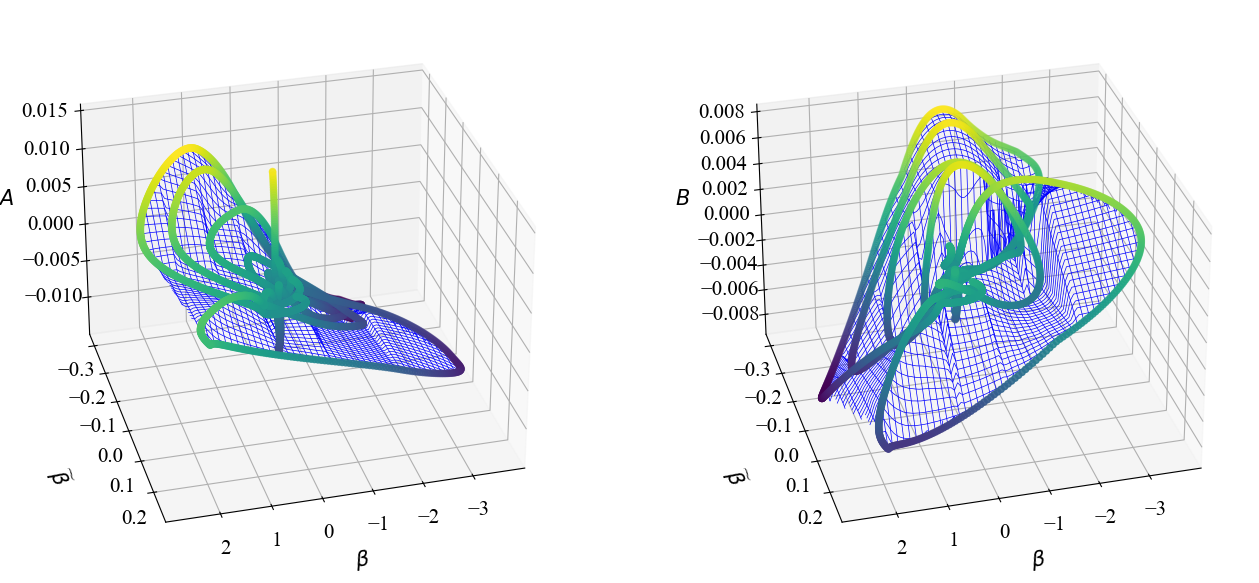

In [13]:
####################################### Attempt in simulating Scattered Interpolant function of Matlab
####################################### Calibration of C4 for the ODE for the displacement thickness evolution
size = 15
del X, Y
X              = beta_all
Y              = BetaOverbar_all
Z              = C4_m_all
Ninterp        = 100
interp_method  = 'linear'
xi,yi          = np.meshgrid(np.linspace(X.min(),X.max(),Ninterp), np.linspace(Y.min(),Y.max(),Ninterp))
zi             = griddata((X, Y), Z, (xi, yi),method=interp_method)
# Create a 3D plot
fig, axes      = plt.subplots(1, 2, figsize=(16, 8), subplot_kw={'projection': '3d'})
ax1            = axes[0]
# Plot the surface as a wireframe mesh
ax1.plot_wireframe(xi, yi, zi, color='blue', linewidth=0.5)
# Scatter plot
sc             = ax1.scatter(X, Y, Z, c=Z, cmap='viridis', marker='o')
ax1.set_xlabel(r'$\beta$', fontname='Times New Roman', fontsize = size, fontstyle='italic', labelpad=10)
ax1.set_ylabel(r'$\widetilde{\beta}$', fontname='Times New Roman', fontsize = size, fontstyle='italic', labelpad=20)
ax1.set_zlabel(r'$A$', fontname='Times New Roman', fontsize = size, fontstyle='italic', labelpad=20)
ax1.view_init(elev=30, azim=75)
ax1.tick_params(axis='z', pad = 10)
######################################## Calibration of C5 for the ODE for the skin friction evolution
Z              = C5_m_all
xi,yi          = np.meshgrid(np.linspace(X.min(),X.max(),Ninterp), np.linspace(Y.min(),Y.max(),Ninterp))
zi             = griddata((X, Y), Z, (xi, yi),method=interp_method)
# Create a 3D plot
ax2            = axes[1]
# Plot the surface as a wireframe mesh
ax2.plot_wireframe(xi, yi, zi, color='blue', linewidth=0.5)
# Scatter plot
sc             = ax2.scatter(X, Y, Z, c=Z, cmap='viridis', marker='o')
ax2.set_xlabel(r'$\beta$', fontname='Times New Roman', fontsize = size, fontstyle='italic', labelpad=10)
ax2.set_ylabel(r'$\widetilde{\beta}$', fontname='Times New Roman', fontsize = size, fontstyle='italic', labelpad=20)
ax2.set_zlabel(r'$B$', fontname='Times New Roman', fontsize = size, fontstyle='italic', labelpad=20)
ax2.view_init(elev=30, azim=75)
ax2.tick_params(axis='z', pad = 10)
# Customize ticks for all subplots
for ax in plt.gcf().get_axes():  # Get all axes in the figure
    ax.tick_params(axis='both', which='major', labelsize=size)  # Set font size for ticks
    for label in (ax.get_xticklabels() + ax.get_yticklabels() + ax.get_zticklabels()):
        label.set_fontname('Times New Roman')  # Set font name for tick labels

In [14]:
########################################################################## Save 
arrays_to_save = [X, Y, C4_m_all, C5_m_all, k]
with open('arrays.pkl','wb') as f:
    pickle.dump(arrays_to_save, f)
###############################################################################

In [27]:
# Solver in the 2D parameter space

for j in range(5):
    
    theta_solver[0,j]         = theta_0
    tau_w_solver[0,j]         = tau_w[0,j]
    delta_star_solver[0,j]    = deltastar[0,j]
    Cf_solver[0,j]            = Cf_c[0,j]
    beta_solver[0,j]          = beta[0,j]
    BetaOverbar_solver[0,j]   = BetaOverbar[0,j]
    
    for i in range(NTOT-2):
        
        # coefficients calibrated beforehand
        C4                          = griddata((X, Y), C4_m_all, (beta_solver[i,j], BetaOverbar_solver[i,j]),method=interp_method,fill_value=0)
        C5                          = griddata((X, Y), C5_m_all, (beta_solver[i,j], BetaOverbar_solver[i,j]),method=interp_method,fill_value=0)
        # 2 ODEs for the closure of the system 
        # Ddelta_star_solverDx[i,j]   = Ddeltastar_zpgDx[i, j] + C4 * deltastar_zpg[i,j];
        # dCfdx_solver[i,j]           = dCf_zpg_dx[i, j]       + C5 * Cf_zpg[i,j];
        Ddelta_star_solverDx[i,j]   = Ddeltastar_zpgDx[i, j] + C4 * delta_star_solver[i,j];
        dCfdx_solver[i,j]           = dCf_zpg_dx[i, j]       + C5 * Cf_solver[i,j];
        # implicit solver
        A                           = 1 - 2 * dpdx[i+1, j] * Dx[i] / rho / (u_inf[i+1, j] ** 2)
        B                           = dpdx[i+1, j] * Dx[i] / rho / (u_inf[i+1, j] ** 2)
        Matrix                      = np.array([[A, -B, -Dx[i] / 2],[0, 1, 0],[0, 0, 1]])
        b                           = np.array([theta_solver[i,j],delta_star_solver[i,j] + Ddelta_star_solverDx[i,j] * Dx[i],Cf_solver[i,j] + dCfdx_solver[i,j] * Dx[i]])
        # Solving the linear system
        a                           = np.linalg.solve(Matrix, b)
        # update of variables
        theta_solver[i+1,j]         = a[0]
        delta_star_solver[i+1,j]    = a[1]
        Cf_solver[i+1,j]            = a[2]
        tau_w_solver[i+1,j]         = Cf_solver[i+1,j]*0.5*rho*u_inf[i+1,j]**2 
        beta_solver[i+1,j]          = dpdx[i+1,j]*delta_star_solver[i+1,j]/tau_w_solver[i+1,j]
        del y1
        y1 = beta_solver[0:i+2,j]
        btilde                      = mov_upstr_mean(y1, len(beta_solver[0:i+2,j]), weight, k)
        BetaOverbar_solver[i+1,j]   = btilde[-1]
        
    

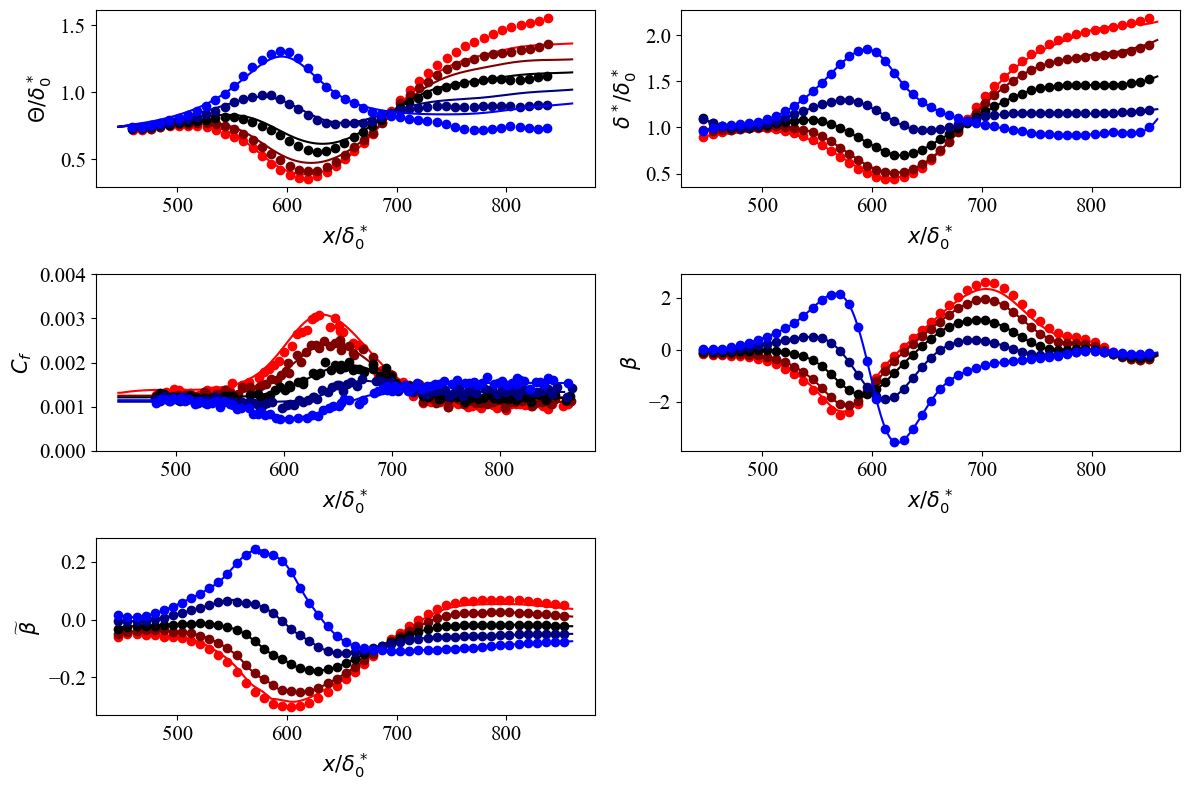

In [30]:
plt.figure(1,figsize=(12, 8))

size = 15

for j in range(5):
    # plot results solver vs measurements
    # Create a 2x2 grid of subplots
    
    ###################################################################### momentum thickness
    plt.subplot(3,2,1)
    plt.plot(x[:-1],theta_solver[:,j],'-',color = color_vel[angle[j]])
    del x1, y1
    x1 = axial_pos1['data'][j]
    y1 = theta_meas['data'][j]
    plt.plot(x1[0,0:-1:200], y1[0,0:-1:200],'o',color = color_vel[angle[j]])
    plt.xlabel(r'$x/\delta_0^*$', fontname='Times New Roman', fontsize = size)
    plt.ylabel(r'$\Theta/\delta_0^*$', fontname='Times New Roman', fontsize = size)
    ################################################################## displacement thickness
    plt.subplot(3,2,2)
    plt.plot(x[:-1], delta_star_solver[:,j],'-',color = color_vel[angle[j]])
    plt.plot(x[0:-1:20], deltastar[0:-1:20,j],   'o',color = color_vel[angle[j]])
    plt.xlabel(r'$x/\delta_0^*$', fontname='Times New Roman', fontsize = size)
    plt.ylabel(r'$\delta^*/\delta_0^*$', fontname='Times New Roman', fontsize = size)
    ############################################################### skin friction coefficient
    plt.subplot(3,2,3)
    plt.plot(x[:-1], (Cf_solver[:,j]*(u_inf[:-1,j]/u0[j])**2)/2,'-',color = color_vel[angle[j]])
    plt.plot(Re[:,j]*ni/u0[j], Cf[:,j],   'o',color = color_vel[angle[j]])
    plt.ylim(0,0.004)
    plt.xlabel(r'$x/\delta_0^*$', fontname='Times New Roman', fontsize = size)
    plt.ylabel(r'$C_f$', fontname='Times New Roman', fontsize = size)
    #################################################################################### beta
    plt.subplot(3,2,4)
    plt.plot(x[:-1], beta_solver[:,j],'-', color = color_vel[angle[j]])
    plt.plot(x[0:-1:20], beta[0:-1:20,j],   'o',color = color_vel[angle[j]])
    plt.xlabel(r'$x/\delta_0^*$', fontname='Times New Roman', fontsize = size)
    plt.ylabel(r'$\beta$', fontname='Times New Roman', fontsize = size)
    ############################################################################ beta overbar
    plt.subplot(3,2,5)
    plt.plot(x[:-1], BetaOverbar_solver[:,j],'-', color = color_vel[angle[j]])
    plt.plot(x[0:-1:20], BetaOverbar[0:-1:20,j],   'o',color = color_vel[angle[j]])
    plt.xlabel(r'$x/\delta_0^*$', fontname='Times New Roman', fontsize = size)
    plt.ylabel(r'$\widetilde{\beta}$', fontname='Times New Roman', fontsize = size)

# Customize ticks for all subplots
for ax in plt.gcf().get_axes():  # Get all axes in the figure
    ax.tick_params(axis='both', which='major', labelsize=size)  # Set font size for ticks
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname('Times New Roman')  # Set font name for tick labels
    
plt.tight_layout()    
plt.show()